In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
from pandas.io.pytables import Fixed
import pymrio
import scipy.io
from matplotlib import colors as mcolors, rc_params
import seaborn as sns
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.markers as mmark
import matplotlib.lines as mlines
from scipy import stats
import country_converter as coco
import matplotlib as mpl
import geopandas
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
cc = coco.CountryConverter(include_obsolete=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [2]:
def plt_rcParams():
    tsize = 4
    tdir = "out"
    major = 5.0
    minor = 3.0
    lwidth = 0.6
    lhandle = 2.0
    plt.style.use("default")
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.size"] = 9
    plt.rcParams["legend.fontsize"] = tsize
    plt.rcParams["xtick.direction"] = tdir
    plt.rcParams["ytick.direction"] = tdir
    plt.rcParams["xtick.major.size"] = major
    plt.rcParams["xtick.minor.size"] = minor
    plt.rcParams["ytick.major.size"] = 3.0
    plt.rcParams["ytick.minor.size"] = 1.0
    plt.rcParams["axes.linewidth"] = lwidth
    plt.rcParams["legend.handlelength"] = lhandle
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["axes.axisbelow"] = True
    plt.rcParams['lines.markersize'] = 3
    return None

plt_rcParams()
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})


In [3]:
world_filepath = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(world_filepath)
print(world[world['name'] == 'Antarctica'])
world = world.drop(world.index[159])
print(world[world['name'] == 'Fr. S. Antarctic Lands'])

world = world.drop(world.index[23])
gdf=world[['name','geometry']]
gdf['region'] = cc.convert(names = gdf['name'], to = 'EXIO3')
gdf['region'].loc[176]='WF'
gdf = gdf.drop('name',axis=1)

     pop_est   continent        name iso_a3  gdp_md_est  \
159     4050  Antarctica  Antarctica    ATA       810.0   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  
    pop_est                continent                    name iso_a3  \
23      140  Seven seas (open ocean)  Fr. S. Antarctic Lands    ATF   

    gdp_md_est                                           geometry  
23        16.0  POLYGON ((68.93500 -48.62500, 69.58000 -48.940...  


S. Sudan not found in regex
C:\Users\andrieba\anaconda3\envs\my_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\andrieba\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
# define top and bottom colormaps 
bottom = cm.get_cmap('Oranges', 128) # r means reversed version
top = cm.get_cmap('Blues_r', 128)
# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

elev_min = -0.99
elev_max = 0.99
mid_val = 0

norm = MidpointNormalize(midpoint=mid_val,vmin=elev_min,vmax=elev_max)

In [5]:
continent = pd.read_excel("continent.xlsx", index_col=0)
sns.color_palette("colorblind", as_cmap="True").append('olive')
color = pd.DataFrame(
    sns.color_palette("colorblind", as_cmap="True")[:11],
    continent["continent"].unique(),
)[0]

handles = []
for i in color.index:
    handles.append(
        mlines.Line2D(
            [],
            [],
            color=color.loc[i],
            linestyle="None",
            marker=".",
            markersize=8,
            label=i,
        )
    )



In [6]:
cm = 1/2.54  # centimeters in inches

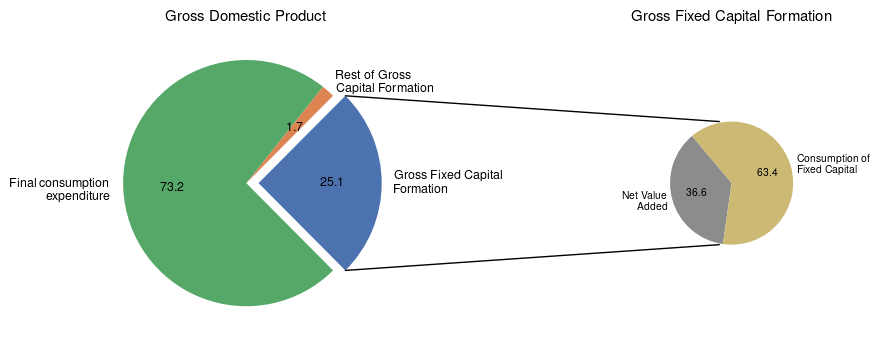

In [7]:
def figure1():

    data = pd.read_excel("Figures/figure1.xlsx", index_col=0, header=0)
    color = sns.color_palette("deep", n_colors=None, desat=None, as_cmap=True)

    # make figure and assign axis objects
    fig = plt.figure(figsize=(9, 5.0625))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(wspace=0)

    # large pie chart parameters

    labels = [
        "Gross Fixed Capital\nFormation",
        "Rest of Gross\nCapital Formation",
        "Final consumption\nexpenditure",
    ]
    ratios = data["pie1"].loc[labels]
    explode = [0.1, 0, 0]
    # rotate so that first wedge is split by the x-axis
    angle = -180 * ratios[0]
    ax1.pie(
        ratios,
        autopct="%1.1f%%",
        startangle=angle,
        labels=labels,
        explode=explode,
        colors=color,
    )

    # small pie chart parameters

    labels = ["Net Value\nAdded", "Consumption of\nFixed Capital"]
    ratios = data["pie2"].loc[labels]
    width = 0.2

    ax2.pie(
        ratios,
        autopct="%1.1f%%",
        startangle=130,
        labels=labels,
        radius=0.5,
        textprops={"size": "smaller"},
        colors=color[7:],
    )

    ax1.set_title("Gross Domestic Product")
    ax2.set_title("Gross Fixed Capital Formation")

    # use ConnectionPatch to draw lines between the two plots
    # get the wedge data
    theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
    center, r = ax1.patches[0].center, ax1.patches[0].r

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(
        xyA=(-width / 2, 0.5),
        xyB=(x, y),
        coordsA="data",
        coordsB="data",
        axesA=ax2,
        axesB=ax1,
    )
    con.set_color([0, 0, 0])
    con.set_linewidth(1)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(
        xyA=(-width / 2, -0.5),
        xyB=(x, y),
        coordsA="data",
        coordsB="data",
        axesA=ax2,
        axesB=ax1,
    )
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(1)
    fig.tight_layout()
    plt.savefig("Figures/figure1a.svg")

    plt.show()

figure1()

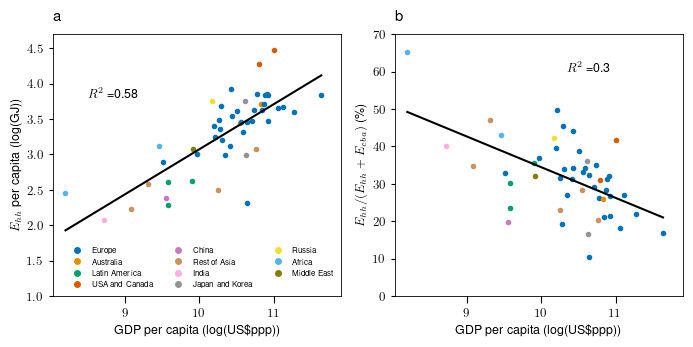

In [8]:
def figure3():
    fig, axes = plt.subplots(1, 2, figsize=(7, 9*cm))
    continent = pd.read_excel("continent.xlsx", index_col=0)

    
    ax = axes[0]
    data = pd.read_excel("Figures/figure3.xlsx", sheet_name="Fig. 3a", index_col=0)
    x = data.T.iloc[0]
    y = data.T.iloc[1]
    regression = pd.read_excel(
        "Figures/figure3.xlsx", sheet_name="Fig. 3a regression", index_col=0
    ).T.values[0]
    for reg in data.index:
        col = color.loc[continent.loc[reg]].values
        ax.scatter(x.loc[reg], y.loc[reg], color=col)
    #for reg in regions_for_scatter:
        #ax.text(x=x.loc[reg], y=y.loc[reg], s=reg)
    ax.plot(
        x,
        (regression[1] + regression[0] * x),
        color="black",
    )
    ax.set_title("")
    ax.set_xlim(right=11.9)
    ax.annotate(
        "$R^2$ =" + str(round(regression[2] ** 2, 2)),
        (8.5, 3.8),
        size=9,
    )
    ax.set_xlabel("GDP per capita (log(US\$ppp))")
    ax.set_ylabel("$E_{hh}$ per capita (log(GJ))")
    ax.set_ylim([1, 4.7])
    ax.set_title("a", loc="left",pad=10) # Direct energy use ($E_{hh}$ per capita)
    ax.legend(handles=handles, loc=4, fontsize=5.8, ncol=3, framealpha=0).set_zorder(0)

    ax = axes[1]
    data = pd.read_excel("Figures/figure3.xlsx", sheet_name="Fig. 3b", index_col=0)
    x = data.T.iloc[0]
    y = data.T.iloc[1]
    regression = pd.read_excel(
        "Figures/figure3.xlsx", sheet_name="Fig. 3b regression", index_col=0
    ).T.values[0]
    for reg in data.index:
        col = color.loc[continent.loc[reg]].values
        ax.scatter(x.loc[reg], y.loc[reg], color=col)
    ax.plot(
        x,
        (regression[1] + regression[0] * x),
        color="black",
    )
    ax.set_title("")
    ax.set_xlim(right=11.9)
    ax.annotate(
        "$R^2$ =" + str(round(regression[2] ** 2, 2)),
        (10.35, 60),
        size=9,
    )
    ax.set_xlabel("GDP per capita (log(US\$ppp))")
    ax.set_ylabel(r"$E_{hh}/(E_{hh}+E_{cba})$" + " (\%)")
    ax.set_ylim([0, 70])
    ax.set_title(
        "b", #+" Direct energy in footprint  (" + r"$\frac{E_{hh}}{E_{hh}+E_{cba}}$" + ")"
        loc="left",pad=10
    )
    #ax.legend(handles=handles, loc=3, fontsize=6, ncol=2, framealpha=1).set_zorder(0)

    plt.tight_layout()
    #plt.savefig("Figures/figure3.png")
    plt.savefig("Figures/figure3.svg")
figure3()

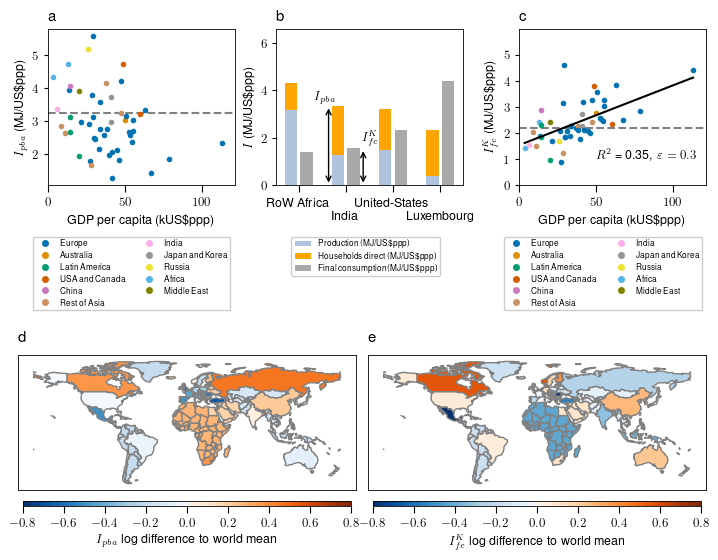

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(7, 5.2))
subfigs = fig.subfigures(2, 1, height_ratios=[1.5, 1])
axs1 = subfigs[1].subplots(1, 2)
axs0 = subfigs[0].subplots(1, 3)
# plt.subplots_adjust( hspace=0.09)

###...................................Fig 4a...................................
ax = axs0[0]


df = pd.read_excel("Figures/figure4.xlsx", sheet_name="Fig. 4a", index_col=0)
world = pd.read_excel("Figures/figure4.xlsx", sheet_name="World values", index_col=0)
y = df["$I_{pba}$ (MJ/2017US\$ppp)"]
x = df["GDP per capita (2017US\$ ppp)"]
for reg in x.index:
    col = color.loc[continent.loc[reg]].values
    ax.scatter(x.loc[reg], (y).loc[reg], color=col)
#for reg in regions_for_scatter:
    #ax.text(x=x.loc[reg], y=(y).loc[reg] + 0.2, s=reg)

ax.axhline(y=world.loc["$I_{pba}$"].values, color="gray", linestyle="--").set_zorder(0)
ax.set_xlabel("GDP per capita (kUS\$ppp)")
ax.set_xlim([0, 121])
ax.set_ylabel("$I_{pba}$ (MJ/US\$ppp)")

ax.legend(
    handles=handles, fontsize=6, ncol=2, framealpha=1,bbox_to_anchor=(1, -0.3)
).set_zorder(0)

###...................................Fig 4b.................................

ax = axs0[1]

reg = ["WF", "IN", "US", "LU"]
df = pd.read_excel("Figures/figure4.xlsx", sheet_name="Fig. 4b", index_col=0).loc[reg]

y1 = df["$E^K_{fc}/Y_{fc}$ (MJ/2017US\$ppp)"]
y2 = df["$E_{hh}/Y$ (MJ/2017US\$ppp)"]
y3 = df["$E_{pba}/Y$ (MJ/2017US\$ppp)"]

ind = np.arange(len(reg))

p1 = ax.bar(ind * 3 + 0.5, y1, color="darkgray")
p2 = ax.bar(ind * 3 - 0.5, y2, color="lightsteelblue")
p3 = ax.bar(ind * 3 - 0.5, y3, bottom=y2, color="orange")


ax.annotate(
    "",
    xy=(1.9, 0),
    xytext=(1.9, (y2 + y3).loc["IN"]),
    arrowprops=dict(arrowstyle="<->", color="black"),
)
ax.text(x=1, y=((y2 + y3).loc["IN"])+0.2, s="$I_{pba}$")
ax.annotate(
    "",
    xy=(4.1, 0),
    xytext=(4.1, y1.loc["IN"]),
    arrowprops=dict(arrowstyle="<->", color="black"),
)
ax.text(x=4, y=(y1.loc["IN"] + 0.3), s="$I_{fc}^{K}$")


ax.set_xticks(ind * 3, ["RoW Africa", "\nIndia", "United-States", "\nLuxembourg"])
ax.set_ylabel("$I$ (MJ/US\$ppp)")
ax.set_ylim([0, 6.6])
ax.legend(
    (p2[0], p3[0],p1[0]),
    (
        "Production (MJ/US\$ppp)",
        "Households direct (MJ/US\$ppp)",
        "Final consumption (MJ/US\$ppp)",
    ),
    framealpha=1,
    fontsize=6,
    bbox_to_anchor=(0.9, -0.3),
)


###...................................Fig 4c.................................
ax = axs0[2]

df = pd.read_excel("Figures/figure4.xlsx", sheet_name="Fig. 4c", index_col=0)
y = df["$I^K_{fc}$ (MJ/2017US\$ppp)"]
x = df["GDP per capita (2017US\$ ppp)"]
regression = pd.read_excel(
    "Figures/figure4.xlsx", sheet_name="Fig. 4c regression", index_col=0
)["regression fig4c"]
for reg in x.index:
    col = color.loc[continent.loc[reg]].values
    ax.scatter(x.loc[reg], y.loc[reg], color=col)
#for reg in regions_for_scatter:
    #ax.text(x=x.loc[reg], y=(y).loc[reg] + 0.2, s=reg)
ax.plot(x, (regression.loc["intercept"] + regression.loc["slope"] * x), color="black")
ax.annotate(
    "$R^2$ = "
    + str(round(regression[2] ** 2, 2))
    + ",   "
    + r"$\varepsilon_{ }^{ } = 0.3$",
    (50, 1),
    size=9,
)


ax.set_ylim(bottom=0)
ax.set_ylim(top=5.99)
ax.set_xlabel("GDP per capita (kUS\$ppp)")
ax.set_xlim([0, 121])

ax.axhline(y=world.loc["$I^K_{fc}$"].values, color="gray", linestyle="--").set_zorder(0)

ax.legend(
    handles=handles, fontsize=6, ncol=2, framealpha=1,bbox_to_anchor=(1, -0.3)
).set_zorder(0)


###...................................Fig 4d.................................

ax = axs1[0]

logdiff_I_K_fc = pd.read_excel(
    "Figures/figure4.xlsx", sheet_name="Fig. 4d", index_col=0
)
gdf2 = gdf.set_index("region")
gdf2["$I_{pba}$ log difference to world mean"] = pd.DataFrame(
    logdiff_I_K_fc, index=gdf["region"]
)
handles = []
for i in color.index:
    handles.append(
        mlines.Line2D(
            [],
            [],
            color=color.loc[i],
            linestyle="None",
            marker=".",
            markersize=8,
            label=i,
        )
    )

elev_min = -0.8
elev_max = 0.8
mid_val = 0
norm = MidpointNormalize(midpoint=mid_val, vmin=elev_min, vmax=elev_max)


ax.set_xticks([])
ax.set_yticks([])
cax = inset_axes(
    ax,
    width="97%",  # width = 5% of parent_bbox width
    height="9%",  # height : 50%
    loc="lower center",
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
gdf2.plot(
    column="$I_{pba}$ log difference to world mean",
    edgecolor="gray",
    ax=ax,
    cmap=orange_blue,
    legend=True,
    legend_kwds={
        "label": "$I_{pba}$ log difference to world mean",
        "orientation": "horizontal",
    },
    norm=norm,
    cax=cax,
)

###...................................Fig 4e.................................

ax = axs1[1]

logdiff_I_K_fc = pd.read_excel(
    "Figures/figure4.xlsx", sheet_name="Fig. 4e", index_col=0
)
gdf2 = gdf.set_index("region")
gdf2["$I^K_{fc}$ log difference to world mean"] = pd.DataFrame(
    logdiff_I_K_fc, index=gdf["region"]
)
handles = []
for i in color.index:
    handles.append(
        mlines.Line2D(
            [],
            [],
            color=color.loc[i],
            linestyle="None",
            marker=".",
            markersize=8,
            label=i,
        )
    )

elev_min = -0.8
elev_max = 0.8
mid_val = 0
norm = MidpointNormalize(midpoint=mid_val, vmin=elev_min, vmax=elev_max)


ax.set_xticks([])
ax.set_yticks([])
cax = inset_axes(
    ax,
    width="97%",  # width = 5% of parent_bbox width
    height="9%",  # height : 50%
    loc="lower center",
    bbox_to_anchor=(0, 0.1, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
gdf2.plot(
    column="$I^K_{fc}$ log difference to world mean",
    edgecolor="gray",
    ax=ax,
    cmap=orange_blue,
    legend=True,
    legend_kwds={
        "label": "$I^K_{fc}$ log difference to world mean",
        "orientation": "horizontal",
    },
    norm=norm,
    cax=cax,
)


###..........................................................................

axs0[0].set_title("a", loc="left")
axs0[1].set_title("b", loc="left")
axs0[2].set_title("c", loc="left")
axs1[0].set_title(
    "d", loc="left", pad=10
)
axs1[1].set_title(
    "e", loc="left", pad=10
)


axs0[2].set_ylabel("$I_{fc}^{K}$ (MJ/US\$ppp)")

plt.savefig("Figures/figure4.svg", bbox_inches="tight", facecolor="w")

C:\Users\andrieba\AppData\Local\Temp/ipykernel_21544/600803205.py:63: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


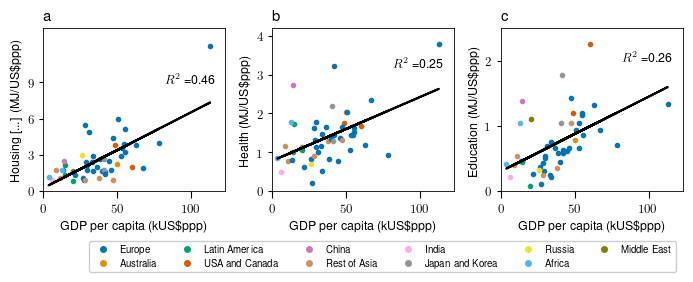

In [10]:
I_K_fc = pd.read_excel('Figures/figure5.xlsx',sheet_name='I_K_fc',index_col=0)
I_K_fc_world = pd.read_excel('Figures/figure5.xlsx',sheet_name='I_K_fc_world',index_col=0)[0]
regression_results = pd.read_excel('Figures/figure5.xlsx',sheet_name='regression_results',index_col=0)
log_diff = pd.read_excel('Figures/figure5.xlsx',sheet_name='log difference to world mean',index_col=0)
real_gdp_cap = pd.read_excel('Figures/figure5.xlsx',sheet_name='real gdp cap',index_col=0)[0]



sectors = ['CPI: 04 - Housing, water, electricity, gas and other fuels','CPI: 06 - Health','CPI: 10 - Education']
titles = ['(a) CPI: 04 - Housing, water, electricity, gas and other fuels','(b) CPI: 06 - Health','(c) CPI: 10 - Education']

fix, ax = plt.subplots(1,3, figsize=(7, 2.5))

pos = [9, 3.2, 2]
eps = [0,0,0]


for j in range(0,3,1):
 
    sect=sectors[j]
    
    x=real_gdp_cap
    y=I_K_fc[sect]
    regression = regression_results[sect]

    for reg in x.index:
        col = color.loc[continent.loc[reg]].values
        ax[j].scatter(x.loc[reg], y.loc[reg], color=col)
    #for reg in regions_for_scatter:
        #ax[j].text(x=x.loc[reg],y=y.loc[reg],s=reg)
    ax[j].plot(
                x,
                regression.loc['intercept'] + regression.loc['slope'] * x,
                color="black",
            )
    ax[j].annotate(
                "$R^2$ =" + str(round(regression.loc['rvalue'] ** 2, 2)),
                (82, pos[j]),
                size=9,
            )
    #ax[j,i].set_title(titles[j,i])
    ax[j].set_xlabel("GDP per capita (kUS\$ppp)")
    ax[j].set_ylim(bottom=0)
    ax[j].set_xlim([0, 123])
ax[0].set_yticks([0,3,6,9])
ax[1].set_yticks([0,1,2,3,4])
ax[2].set_yticks([0,1,2])

ax[0].set_ylim(top=13.5)
ax[1].set_ylim(top=4.2)
ax[2].set_ylim(top=2.5)

ax[0].set_ylabel('Housing [...] (MJ/US\$ppp)')
ax[1].set_ylabel('Health (MJ/US\$ppp)')
ax[2].set_ylabel('Education (MJ/US\$ppp)')

ax[0].set_title('a',loc='left')
ax[1].set_title('b',loc='left')
ax[2].set_title('c',loc='left')

plt.tight_layout()
ax[0].legend(handles=handles,loc=0,fontsize=7,ncol=6,framealpha=1,bbox_to_anchor=(3.5, -0.28)).set_zorder(0)
plt.tight_layout()

plt.savefig('Figures/figure5.svg', bbox_inches = 'tight', facecolor='w')

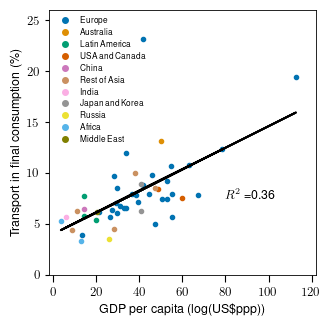

In [14]:
def figure6():
    
    sect_shares = pd.read_excel(
        "Figures/figure6.xlsx", sheet_name="sector shares", header=0, index_col=0
    )
    regression_results = pd.read_excel(
        "Figures/figure6.xlsx", sheet_name="regression_results", header=0, index_col=0
    )
    x = sect_shares["real gdp cap"]
    y = sect_shares["CPI: 07 - Transport"]*100
    regression = regression_results["CPI: 07 - Transport"]


    plt.rcParams.update({"text.usetex": True})
    fig, ax = plt.subplots(1, figsize=(3.33,3.33))

    for reg in x.index:
        col = color.loc[continent.loc[reg]].values
        ax.scatter(x.loc[reg], y.loc[reg], color=col)

    ax.plot(
        x,
        (regression.loc["intercept"] + regression.loc["slope"] * x)*100,
        color="black",
    )
    ax.set_title("")
    ax.set_ylim([0,26])
    ax.set_xlim(right=122)
    ax.set_xlabel("GDP per capita (log(US\$ppp))")
    ax.set_ylabel("Transport in final consumption (\%)")
    ax.annotate(
        "$R^2$ =" + str(round(regression.loc["R2"], 2)),
        (80, 7.5),
        size=9,
    )
    ax.legend(handles=handles, loc=0, fontsize=6, ncol=1, framealpha=0).set_zorder(0)
    plt.tight_layout()
    plt.savefig("Figures/figure6.svg")
figure6()

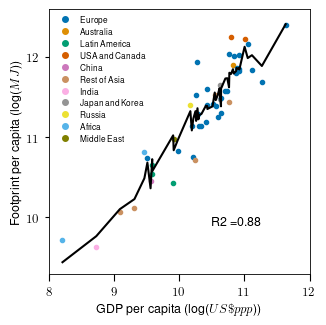

In [15]:
def figure7():
    data = pd.read_excel("Figures/figure7.xlsx", header=0, index_col=0)

    plt.rcParams.update({"text.usetex": True})
    fig, ax = plt.subplots(1, figsize=(3.33,3.33))

    x = np.log(data["real_gdp_cap"])
    y = np.log(data["GJ/capita"])
    ycalc = np.log(data["GJ/capita calculated"])

    for reg in data.index:
        col = color.loc[continent.loc[reg]].values
        ax.scatter(x.loc[reg], y.loc[reg], color=col)

    ax.plot(
        x,
        ycalc,
        color="black",
    )

    ax.set_title("")

    from sklearn.metrics import r2_score

    ax.annotate(
        "R2 =" + str(round(r2_score((y), (ycalc)), 2)),
        (10.5, 9.9),
        size=9,
    )
    ax.set_xlabel("GDP per capita (log($US\$ppp$))")
    ax.set_ylabel("Footprint per capita (log($MJ$))")
    ax.legend(handles=handles, loc=2, fontsize=6, ncol=1,framealpha=0).set_zorder(0)
    ax.set_xlim(right=12)
    ax.set_ylim(top=12.6)
    ax.set_yticks([10,11,12])
    ax.set_xticks([8,9,10,11,12])
    plt.tight_layout()
    plt.savefig("Figures/figure7.svg")

figure7()

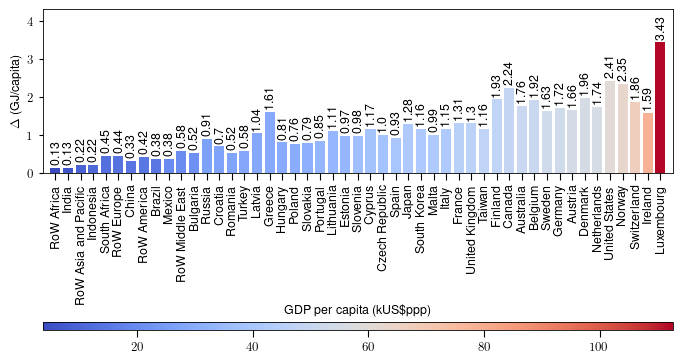

In [17]:
def figure8():
    data = pd.read_excel("Figures/figure8.xlsx", header=0, index_col=0)

    data_x = data.index
    data_height = data["delta"] / 1000
    data_color = data["gdp"] / 1000

    # data_color = [x / max(data_color) for x in data_color]
    norm = plt.Normalize(min(data_color), max(data_color))
    fig, ax = plt.subplots(figsize=(7, 4.7))

    my_cmap = plt.cm.get_cmap("coolwarm")
    colors = my_cmap(norm(data_color))
    rects = ax.bar(data_x, data_height, color=colors, label=data.index)

    sm = ScalarMappable(cmap=my_cmap, norm=norm)
    sm.set_array([])

    cbar = plt.colorbar(sm,orientation='horizontal',location='bottom',fraction=0.11,shrink=1,aspect=80,anchor=(-0.5, -6))
    cbar.set_label("GDP per capita (kUS\$ppp)", rotation=0, labelpad=-35)

    for x in data.index:

        ax.text(
            x,
            0.07+ data_height.loc[x],
            str(round(data_height.loc[x],2)),
            ha="center",
            va="bottom",rotation=90
        )

    plt.xticks(data_x, rotation="vertical")

    plt.ylabel("$\Delta$ (GJ/capita)")
    ax.set_xlim([-1, 49])
    ax.set_ylim(top=4.3)
    plt.tight_layout()
    

    plt.savefig("Figures/figure8.svg")

figure8()